# Test SINDy on a Simple Pendulum System

This code demonstrates how to use the SparseNonLinearModel class to identify the governing equations of a non-linear dynamical system with a forced input.

The system used in these examples is a [simple pendulum system](https://services.math.duke.edu/education/ccp/materials/diffeq/pendulum/pend1.html) of ordinary differential equations.

Contents:
1. Generate data by simulating pendulum
2. Identify system dynamics using sparse regression
 1. Using SparseNonLinearModel class
 2. Using identified model for prediction
 3. Estimation from 10 data points

References:

1. Brunton, S. L., & Kutz, J. N. (2019). Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control (1st ed.). Cambridge University Press. http://www.databookuw.com

In [1]:
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d

# Local modules
from dynopt.models.models import NonLinearModel, SparseNonLinearModel

%matplotlib inline

# 1. Generate data by simulating pendulum

In [2]:
# System equations

def pendulum_dydt(t, y, u, m=1, L=2, g=-10, b=1):
    """Simulates the non-linear dynamics of a simple pendulum system.
    These non-linear ordinary differential equations (ODEs) return the
    time-derivative at the current time given the current state of the
    system.
    
    Args:
        t (float): Time variable - not used here but included for
            compatibility with solvers like scipy.integrate.solve_ivp.
        y (np.array): State vector. This should be an array of
            shape (2, ) containing the current state of the system.
            y[0] is the angle (theta) in radians of the pendulum from
            the vertical down position and y[1] is the angular 
            velocity (dtheta/dt).
        u (function): u(t) is a function which should return the 
            torque applied to shaft.
        m (float): Mass of pendulum.
        L (float): Length of pendulum.
        g (float): Acceleration due to gravity.
        b (float): Damping coefficient for joint friction (proportional
            to angular velocity).
    Returns:
        dydt (np.array): The time derivate of the state (dy/dt) as a
            shape (2, ) array.
    """

    dydt = np.empty_like(y)
    dydt[0] = y[1]
    dydt[1] = -(b/m) * y[1] + (g/L) * np.sin(y[0]) + u(t) / L

    return dydt

In [3]:
dt = 0.01
T = 10
t = np.arange(0, T + dt, dt)

In [4]:
# Cart-pendulum system parameters (constants)
params = {
    'm': 1,  # Mass of pendulum
    'L': 2,  # Length of pendulum
    'g': -10,  # Acceleration due to gravity
    'b': 1  # Damping coefficient for joint friction
}

In [5]:
# Initial condition
x0 = [np.pi, 0]  # Pendulum up position

In [6]:
# Control input
u = -2*np.sin(t*(1+t/20))  # Sine function with varying frequency

uf = interp1d(t, u, kind='previous')
u = u[:-1]
assert u.shape == (1000,), u.shape

# u is a function defined in this range
uf(t[0]), uf(t[-1])

(array(-0.), array(-1.30057568))

In [7]:
dYdt = pendulum_dydt(t[0], x0, u=uf, **params)
dYdt

array([ 0.000000e+00, -6.123234e-16])

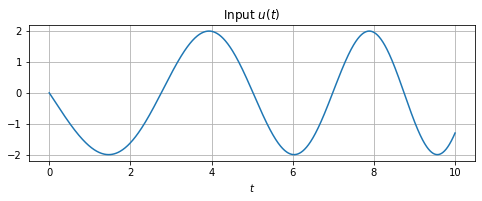

In [8]:
plt.figure(figsize=(8,2.5))
plt.plot(t, uf(t))
plt.title('Input $u(t)$')
plt.xlabel('$t$')
plt.grid()

In [9]:
%%time

# Simulate using scipy.integrate.odeint method
# Produces same results as Matlab
fun = partial(pendulum_dydt, u=uf, **params)
rtol = 10e-12
atol = 10e-12 * np.ones_like(x0)
X = odeint(fun, x0, t[:-1], tfirst=True, rtol=rtol, atol=atol)
assert X.shape == (1000, 2), X.shape

CPU times: user 9.81 s, sys: 166 ms, total: 9.97 s
Wall time: 9.85 s


In [10]:
X[:5].round(3)

array([[ 3.142e+00,  0.000e+00],
       [ 3.142e+00, -0.000e+00],
       [ 3.142e+00, -0.000e+00],
       [ 3.142e+00, -0.000e+00],
       [ 3.142e+00, -1.000e-03]])

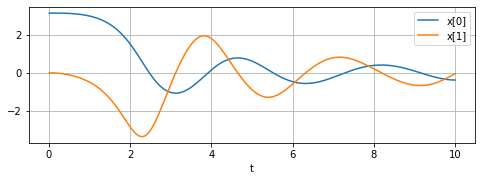

In [11]:
fig, ax = plt.subplots(figsize=(8,2.5))
for i in range(X.shape[1]):
    plt.plot(t[1:], X[:,i], label=f'x[{i}]')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.show()

In [12]:
# Calculate derivatives (vectorized version)
dXdt = pendulum_dydt(t[:-1], X.T, uf, **params).T
assert dXdt.shape == (1000, 2)

## 2. Identify system dynamics using sparse regression

### A. Using SparseNonLinearModel class

In [13]:
# Labels for inputs and outputs
x_names = ['theta', 'theta_dot', 'u']
y_names = ['theta_dot', 'theta_ddot']

# Choose additional features for model identification
custom_features = ['sin(x0)', 'cos(x0)', 'sin(x0)**2', 
                   'cos(x0)**2', 'sin(x0)*cos(x0)']

poly_order = 2
model = SparseNonLinearModel(x_names, y_names, 
                             custom_features=custom_features,
                             poly_order=poly_order)
model

SparseNonLinearModel(['theta', 'theta_dot', 'u'], ['theta_dot', 'theta_ddot'], estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), custom_features=['sin(x0)', 'cos(x0)', 'sin(x0)**2', 'cos(x0)**2', 'sin(x0)*cos(x0)'], poly_order=2)

In [14]:
dXdt = pd.DataFrame(dXdt, columns=y_names)
dXdt.head()

,theta_dot,theta_ddot
0,0.000000e+00,-6.123234e-16
1,-1.348867e-11,-1.000483e-02
2,-9.955803e-05,-1.992160e-02
3,-2.978226e-04,-2.975509e-02
4,-5.939895e-04,-3.951002e-02


In [15]:
X_u = pd.DataFrame(np.hstack([X, u.reshape(-1, 1)]), columns=x_names)
X_u.head()

,theta,theta_dot,u
0,3.141593,0.000000e+00,-0.000000
1,3.141593,-1.348867e-11,-0.020010
2,3.141592,-9.955803e-05,-0.040037
3,3.141590,-2.978226e-04,-0.060081
4,3.141586,-5.939895e-04,-0.080139


In [16]:
threshold = 0.2
model.fit(X_u, dXdt, threshold=threshold)

model.n_params

4

In [17]:
model.x_features

['x1', 'x2', 'sin(x0)']

In [18]:
# R-squared
model.score(X_u, dXdt)

1.0

In [19]:
# Display coefficients
model.intercept_

y0    0.0
y1    0.0
dtype: float64

In [20]:
model.coef_

,x1,x2,sin(x0)
y0,1.0,0.0,0.0
y1,-1.0,0.5,-5.0


In [21]:
# True model equations 
# y0 = dxdt[0] = x[1]
# y1 = dxdt[1] = -(b/m) * x[1] + (g/L) * np.sin(x[0]) + x[2] / L

In [22]:
-params['b'] / params['m']

-1.0

In [23]:
params['g'] / params['L']

-5.0

In [24]:
1 / params['L']

0.5

In [25]:
dXdt.loc[0:3]

,theta_dot,theta_ddot
0,0.000000e+00,-6.123234e-16
1,-1.348867e-11,-1.000483e-02
2,-9.955803e-05,-1.992160e-02
3,-2.978226e-04,-2.975509e-02


## B. Using identified model for prediction

In [26]:
X_u_sample = X_u.loc[0:5]
X_u_sample

,theta,theta_dot,u
0,3.141593,0.000000e+00,-0.000000
1,3.141593,-1.348867e-11,-0.020010
2,3.141592,-9.955803e-05,-0.040037
3,3.141590,-2.978226e-04,-0.060081
4,3.141586,-5.939895e-04,-0.080139
5,3.141578,-9.873016e-04,-0.100208


In [27]:
model.predict(X_u_sample)

,theta_dot,theta_ddot
0,0.000000e+00,-6.123234e-16
1,-1.348867e-11,-1.000483e-02
2,-9.955803e-05,-1.992160e-02
3,-2.978226e-04,-2.975509e-02
4,-5.939895e-04,-3.951002e-02
5,-9.873016e-04,-4.919100e-02


In [28]:
# For one-step ahead prediction use dicts or Series
x_u = {
    'theta': np.pi, 
    'theta_dot': 0, 
    'u': 0
}
model.predict(x_u)

{'theta_dot': 0.0, 'theta_ddot': -6.123233995736762e-16}

## C. Estimation from 10 data points

In [29]:
# The following data points were randomly sampled
# from a time-series generated by simulating a 
# simple pendulum with the following equations
# Pendulum system dynamics:
# y[0] = dXdt[0] = x[1]
# y[1] = dXdt[1] = -(b/m) * x[1] + (g/L) * np.sin(x[0]) + u(t) / L
# with m=1, L=2, g=-10, b=1 and X0 = [pi, 0]

X_u_data = np.array([
    [-0.31337, -0.35066, -1.95775],
    [ 0.43377,  0.1971 ,  0.12873],
    [ 0.02058, -0.97899, -0.13313],
    [-0.64254, -2.22694, -0.583  ],
    [ 0.13985, -0.35462, -0.13526],
    [ 0.29423,  0.4599 ,  1.98026],
    [ 0.29177, -0.34668,  0.43937],
    [-0.17303, -0.78595, -0.89596],
    [ 0.3605 , -0.48347, -1.54148],
    [ 0.33364, -0.20928,  0.92452]
])

dXdt_data = np.array([
    [-0.35066,  0.91312],
    [ 0.1971 , -2.23421],
    [-0.97899,  0.80954],
    [-2.22694,  4.93158],
    [-0.35462, -0.40998],
    [ 0.4599 , -0.91979],
    [-0.34668, -0.87185],
    [-0.78595,  1.19881],
    [-0.48347, -2.05099],
    [-0.20928, -0.9659 ]
])

x_names = ['theta', 'theta_dot', 'u']
y_names = ['theta_dot', 'theta_ddot']
X_u = pd.DataFrame(X_u_data, columns=x_names)
dXdt = pd.DataFrame(dXdt_data, columns=y_names)

custom_features = ['sin(x0)', 'cos(x0)', 'sin(x0)**2', 
                   'cos(x0)**2', 'sin(x0)*cos(x0)']

model = SparseNonLinearModel(x_names, y_names, 
                             custom_features=custom_features,
                             poly_order=2)

model.fit(X_u, dXdt, threshold=0.2)
print(f"Number of parameters: {model.n_params}")
print(f"Coefficients\n{model.coef_}")
print(f"Intercepts\n{model.intercept_}")
print(f"R-squared: {model.score(X_u, dXdt):.3f}")

Number of parameters: 4
Coefficients
          x1        x2   sin(x0)
y0  1.000000  0.000000  0.000000
y1 -0.999997  0.499999 -4.999998
Intercepts
y0    0.0
y1    0.0
dtype: float64
R-squared: 1.000
